In [13]:
import matplotlib.pyplot as plt 
import json
from glob import glob

from collections import defaultdict
import os
import numpy as np

import pandas as pd


dataset_names=[
    "adult",
    "electricity",
    "forest_cover",
    "hyperplane_high_gradual_drift",
    "insects",
    "movingRBF",
    "moving_squares",
    "new_airlines",
    "rialto",
    "river_aggrawal",
    "river_anomalysine",
    "river_hyperlane_2",
    "river_hyperlane",
    "river_led",
    "river_led_default_drift",
    "river_mixed",
    "river_randomRBF_2",
    "river_randomRBF",
    "river_randomRBF_drift",
    "river_randomTree_2",
    "river_randomTree",
    "river_SEA_2",
    "river_SEA",
    "river_SINE",
    "river_STAGGER",
    "river_Waveform-2",
    "river_Waveform",
    "sea_high_abrupt_drift",
    "sea_high_mixed_drift",
    "shuttle",
    "skmul_aggrawal",
    "skmul_anomalysine_2",
    "skmul_anomalysine",
    "skmul_hyperlane",
    "skmul_ledgenerator",
    "skmul_ledgenerator_default_drift",
    "skmul_randomRBF_default_drift",
    "skmul_randomRBF_gradual",
    "skmul_randomTree_2",
    "skmul_randomTree",
    "skmul_SEA_2",
    "skmul_SEA",
    "skmul_Sine",
    "skmul_STAGGER_2",
    "skmul_STAGGER",
    "skmul_Waveform",
    "synth_agrawal",
    "synth_RandomRBFDrift",
    "vehicle_sensIT",
    "weather"
]



model_names=('HATC','ARFC','AutoClass','AutoStreamML','SRPC', 'EvoAutoML',"OnlineAutoML")


dataset_by_model={}
for dataset in dataset_names:
    dataset_by_model[dataset]={}

for model in model_names:
    for dataset in dataset_names:
        dataset_by_model[dataset][model]=glob(f'./experiment-results/{model}/{model}_{dataset}*')

In [14]:
import re
import json
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm.notebook import tqdm
import re


def extract_dataset_name(filepath, framework):
    """Extract dataset name that appears between framework prefix and 'seed_'."""
    pattern = re.escape(framework) + r'_(.+?)_seed'
    match = re.search(pattern, filepath)
    return match.group(1) if match else None


def extract_config(filepath, framework):
    """Extract config parameters based on framework."""
    try:
        dataset = extract_dataset_name(filepath, framework)
        if not dataset:
            raise ValueError("Dataset name not found")

        if framework == 'AutoStreamML':
            return {
                'dataset': dataset,
                'seed': int(re.search(r'seed_(\d+)', filepath).group(1)),
                'exploration_window': int(re.search(r'exploration_window_(\d+)', filepath).group(1)),
                'ensemble_size': int(re.search(r'ensemble_size_(\d+)', filepath).group(1)),
                'budget': int(re.search(r'budget_(\d+)', filepath).group(1)),
                'framework': framework,
                'filepath': filepath
            }
        elif framework == 'EvoAutoML':
            return {
                'dataset': dataset,
                'seed': int(re.search(r'seed_(\d+)', filepath).group(1)),
                'population_size': int(re.search(r'population_size_(\d+)', filepath).group(1)),
                'sampling_size': int(re.search(r'sampling_size_(\d+)', filepath).group(1)),
                'sampling_rate': int(re.search(r'sampling_rate_(\d+)', filepath).group(1)),
                'framework': framework,
                'filepath': filepath
            }
        elif framework == 'OnlineAutoML':
            return {
                'dataset': dataset,
                'seed': int(re.search(r'seed_(\d+)', filepath).group(1)),
                'ensemble_size': int(re.search(r'ensemble_size_(\d+)', filepath).group(1)),
                'time_budget': int(re.search(r'time_budget_(\d+)', filepath).group(1)),
                'initialBatch': int(re.search(r'initialBatch_(\d+)', filepath).group(1)),
                'cache': int(re.search(r'cache_(\d+)', filepath).group(1)),
                'framework': framework,
                'filepath': filepath
            }
        elif framework == 'AutoClass':
            return {
                'dataset': dataset,
                'seed': int(re.search(r'seed_(\d+)', filepath).group(1)),
                'population_size': int(re.search(r'population_size_(\d+)', filepath).group(1)),
                'exploration_window': int(re.search(r'exploration_window_(\d+)', filepath).group(1)),
                'framework': framework,
                'filepath': filepath
            }
        else:
            raise ValueError(f"Unknown framework: {framework}")
    except Exception as e:

        return None



def process_file_wrapper(args):
    """Enhanced processor with temporal analysis for OnlineAutoML"""
    filepath, metrics, framework = args
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
            results = {'framework': framework}
            
            for metric in metrics:
                if metric in data:
                    values = np.array(data[metric])
                    
                    # Standard processing for most metrics
                    if metric != 'time' or framework != 'OnlineAutoML':
                        if metric == 'energy_consumed':
                            values *= 3600000
                        results[metric] = np.mean(values)
                    
                    # Special handling for OnlineAutoML time
                    else:
                        values *= 1000  # Convert to milliseconds
                        results.update({
                            'time': np.median(values),
                            'time_median': np.median(values),
                            'time_std': np.std(values),
                            'time_max': np.max(values),
                            'time_p90': np.percentile(values, 90),
                            'time_instability': np.mean(np.abs(np.diff(values)))  # Measures volatility
                        })
                        
                        # Add phase-specific metrics
                        split_points = [0, len(values)//3, 2*len(values)//3, len(values)]
                        for i, phase in enumerate(['early', 'mid', 'late']):
                            phase_values = values[split_points[i]:split_points[i+1]]
                            results.update({
                                f'time_{phase}_mean': np.mean(phase_values),
                                f'time_{phase}_p90': np.percentile(phase_values, 90)
                            })
            
            return results
            
    except Exception as e:

        return None

def gather_all_configs(dataset_by_model, framework, metrics=['energy_consumed', 'prequential_scores','time'], workers=4):
    """Collect configurations for a specific framework."""
    all_files = []
    for dataset in dataset_by_model.keys():
        if framework in dataset_by_model[dataset]:
            all_files.extend([(fp, metrics, framework) 
                           for fp in dataset_by_model[dataset][framework]])
    
    results = []
    with ProcessPoolExecutor(max_workers=workers) as executor:
        futures = [executor.submit(process_file_wrapper, args) for args in all_files]
        
        for i, future in enumerate(futures):
            filepath = all_files[i][0]
            metric_values = future.result()
            config = extract_config(filepath, framework)
            if config and metric_values:
                config.update(metric_values)
                results.append(config)
    
    return pd.DataFrame(results)




oaml_df = gather_all_configs(dataset_by_model, 'OnlineAutoML')
autostream_df = gather_all_configs(dataset_by_model,'AutoStreamML')
evoautoml_df = gather_all_configs(dataset_by_model,'EvoAutoML')
autoclass_df = gather_all_configs(dataset_by_model,'AutoClass')



In [15]:
autostream_df.to_csv('downsized_results_csv/autostream_results.csv', index=False)
evoautoml_df.to_csv('downsized_results_csv/evoautoml_results.csv', index=False)
autoclass_df.to_csv('downsized_results_csv/autoclass_results.csv', index=False)
oaml_df.to_csv('downsized_results_csv/onlineautoml_results.csv', index=False)

In [16]:
import pandas as pd
autostream_df = pd.read_csv('downsized_results_csv/autostream_results.csv')
evoautoml_df=pd.read_csv('downsized_results_csv/evoautoml_results.csv')
autoclass_df=pd.read_csv('downsized_results_csv/autoclass_results.csv')
oaml_df=pd.read_csv('downsized_results_csv/onlineautoml_results.csv')

In [17]:
def analyze_parameter(df, parameter_name, protected_parameters={}, metrics=None):
    """
    Analyze the impact of a parameter on all metrics using Friedman + autorank CD plot.
    Ensures strict pairing by filtering all protected parameters and sorting by 'filepath'.

    Args:
        df: DataFrame containing the experimental results.
        parameter_name: Name of the parameter to analyze (e.g., 'budget').
        protected_parameters: Dict of fixed values for other parameters (e.g., {'ensemble_size': 3}).
        metrics: List of metrics to analyze (default: ['prequential_scores', 'energy_consumed', 'time'])
    """
    import matplotlib.pyplot as plt
    from autorank import autorank, plot_stats

    if metrics is None:
        metrics = ['prequential_scores', 'energy_consumed', 'time']

    print(f"\n=== Analyzing {df['framework'].iloc[0]} ===")
    print(f"Protected parameters: {protected_parameters}")
    print(f"Analyzing parameter: {parameter_name}")
    print(f"Available values: {sorted(df[parameter_name].unique())}")

    # Apply protected parameter filtering
    # for key, val in protected_parameters.items():
    #     df = df[df[key] == val]

    param_values = sorted(df[parameter_name].unique())

    for metric in metrics:
        try:
            print(f"\n--- Analysis for {metric} ---")
            groups = []

            for value in param_values:
                filtered = df[df[parameter_name] == value]
                filtered_metric = filtered.sort_values(by='filepath')[metric]
                groups.append(filtered_metric.reset_index(drop=True))

            # Combine groups into aligned DataFrame
            data_for_autorank = pd.DataFrame({str(v): g for v, g in zip(param_values, groups)})
            data_for_autorank = data_for_autorank.dropna()

            if data_for_autorank.shape[0] < 2:
                print("Not enough paired samples.")
                continue

            print(f"Paired samples: {data_for_autorank.shape[0]}")

            # Determine ranking direction
            if metric in ['time', 'energy_consumed']:
                order_ = 'ascending'
            else:
                order_ = 'descending'

            result = autorank(data_for_autorank, order=order_, verbose=False, force_mode='nonparametric', random_state=42)
            # print(result)

            plot_stats(result, allow_insignificant=True)
                        # Customize title font size
            print("METRIC", metric)
            if metric == 'prequential_scores':
                title_metric='Prequential Accuracy'
            elif metric == 'energy_consumed':
                title_metric='Energy Consumption'
            if metric == 'time':
                title_metric='Inference Time'

            if df['framework'].iloc[0]=='AutoStreamML':
                df['framework'].iloc[0]='ASML'

                
           

            
            plt.tight_layout()

            if parameter_name in ['sampling_rate', 'cache','exploration_window']:
                save_param='exploration_window'
            elif parameter_name in ['population_size']:
                save_param='population_size'
            elif parameter_name in ['ensemble_size']:
                save_param='ensemble_size'
            else:
                save_param='special'

            if save_param=='special':
                save_path_cd=f"cd_diagrams of configs/{save_param}/{df['framework'].iloc[0]}/{metric}.png"
                plt.title(f"{title_metric}", fontsize=20)
            else:
                save_path_cd=f"cd_diagrams of configs/{save_param}/{metric}/{df['framework'].iloc[0]}.png"
                plt.title(f"{df['framework'].iloc[0]}", fontsize=20)

            print(save_path_cd)

            # Title and save
            # plt.title(f"{df['framework'].iloc[0]} - {metric}", fontsize=16)

            os.makedirs(os.path.dirname(save_path_cd), exist_ok=True)
            plt.savefig(save_path_cd, dpi=300, bbox_inches='tight')
            print(f"Saved CD diagram to {save_path_cd}")
            plt.show()

        except Exception as e:
            print(f"Error during autorank for {metric}: {str(e)}")



plt.rcParams.update({'font.size': 19})




=== Analyzing OnlineAutoML ===
Protected parameters: {}
Analyzing parameter: cache
Available values: [1000, 2000, 3000]

--- Analysis for prequential_scores ---
Paired samples: 254
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
3000  2.244094  0.706130  0.158269  0.638198  0.790588         0.0   
2000  2.023622  0.794660  0.082817  0.756316  0.806262   -0.472747   
1000  1.732283  0.817871  0.107828  0.791551  0.862402   -0.556559   

       magnitude effect_size_above magnitude_above  
3000  negligible               0.0      negligible  
2000       small         -0.472747           small  
1000      medium         -0.162844      negligible  
METRIC prequential_scores
cd_diagrams of configs/exploration_window/prequential_scores/OnlineAutoML.png
Saved CD diagram to cd_diagrams of configs/exploration_window/prequential_scores/OnlineAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


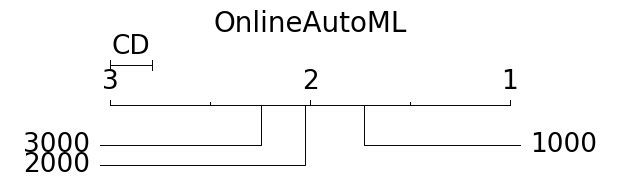


--- Analysis for energy_consumed ---
Paired samples: 254
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


      meanrank    median       mad  ci_lower  ci_upper effect_size  \
3000  1.629921  1.801946  0.611563  1.588708  2.227392         0.0   
2000  2.181102  2.790251  1.194222  2.280343  3.413001   -0.702627   
1000  2.188976  2.405580  0.760063   2.16912   2.94335   -0.590219   

       magnitude effect_size_above magnitude_above  
3000  negligible               0.0      negligible  
2000      medium         -0.702627          medium  
1000      medium          0.259208           small  
METRIC energy_consumed
cd_diagrams of configs/exploration_window/energy_consumed/OnlineAutoML.png
Saved CD diagram to cd_diagrams of configs/exploration_window/energy_consumed/OnlineAutoML.png


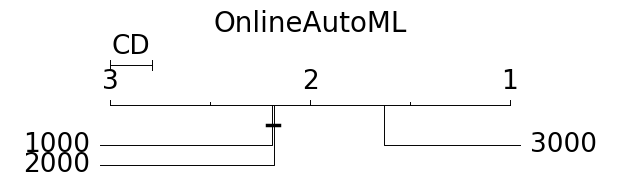


--- Analysis for time ---
Paired samples: 254
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
3000  1.358268  1.195908  0.583827  0.910521  1.487732         0.0   
2000  2.169291  2.872705  1.710534  2.323985  3.708601   -0.884936   
1000  2.472441  4.074574  2.359509  3.140211  5.061746   -1.129684   

       magnitude effect_size_above magnitude_above  
3000  negligible               0.0      negligible  
2000       large         -0.884936           large  
1000       large          -0.39338           small  
METRIC time
cd_diagrams of configs/exploration_window/time/OnlineAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/time/OnlineAutoML.png


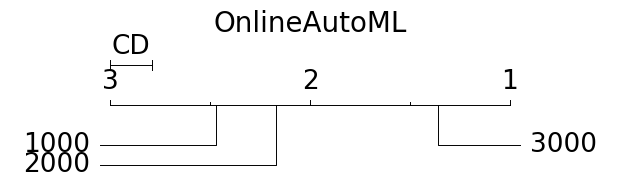


=== Analyzing EvoAutoML ===
Protected parameters: {}
Analyzing parameter: sampling_rate
Available values: [1000, 2000, 3000]

--- Analysis for prequential_scores ---
Paired samples: 277
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
1000  2.072202  0.829266  0.064152  0.820218   0.85232         0.0   
3000  2.036101  0.842559  0.079409  0.824047  0.879268   -0.124208   
2000  1.891697  0.865620  0.053149  0.836642  0.883144   -0.416258   

       magnitude effect_size_above magnitude_above  
1000  negligible               0.0      negligible  
3000  negligible         -0.124208      negligible  
2000       small         -0.230214           small  
METRIC prequential_scores
cd_diagrams of configs/exploration_window/prequential_scores/EvoAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/prequential_scores/EvoAutoML.png


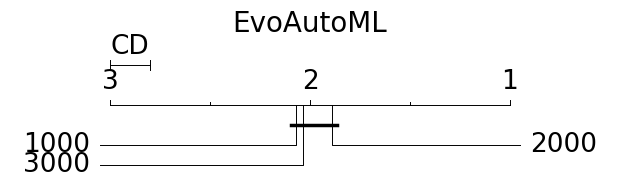


--- Analysis for energy_consumed ---
Paired samples: 277
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
3000  1.866426  0.825249  0.224441  0.768581  0.956315         0.0   
2000  1.981949  0.799438  0.230734  0.709888  0.934457    0.076489   
1000  2.151625  0.949343  0.311312  0.806458  1.102049    -0.30843   

       magnitude effect_size_above magnitude_above  
3000  negligible               0.0      negligible  
2000  negligible          0.076489      negligible  
1000       small         -0.369013           small  
METRIC energy_consumed
cd_diagrams of configs/exploration_window/energy_consumed/EvoAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/energy_consumed/EvoAutoML.png


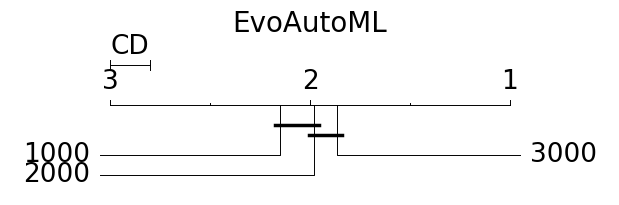


--- Analysis for time ---
Paired samples: 277
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
3000  1.960289  0.006741  0.002541  0.005345  0.007494         0.0   
2000  1.967509  0.006170  0.002055  0.004777  0.006995     0.16659   
1000  2.072202  0.007007  0.002793  0.005109  0.007962   -0.067371   

       magnitude effect_size_above magnitude_above  
3000  negligible               0.0      negligible  
2000  negligible           0.16659      negligible  
1000  negligible         -0.230358           small  
METRIC time
cd_diagrams of configs/exploration_window/time/EvoAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/time/EvoAutoML.png


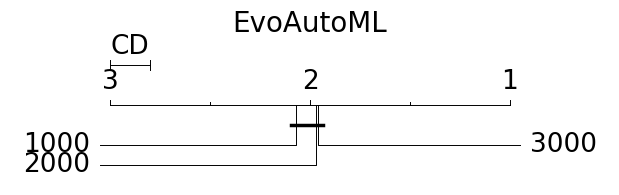


=== Analyzing AutoClass ===
Protected parameters: {}
Analyzing parameter: exploration_window
Available values: [1000, 2000, 3000]

--- Analysis for prequential_scores ---
Paired samples: 319
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
2000  2.015674  0.801930  0.095959  0.782965  0.851891         0.0   
3000  2.000000  0.802098  0.095295  0.781685  0.851641   -0.001181   
1000  1.984326  0.793236  0.058735  0.779591  0.849817    0.073708   

       magnitude effect_size_above magnitude_above  
2000  negligible               0.0      negligible  
3000  negligible         -0.001181      negligible  
1000  negligible          0.075508      negligible  
METRIC prequential_scores
cd_diagrams of configs/exploration_window/prequential_scores/AutoClass.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/prequential_scores/AutoClass.png


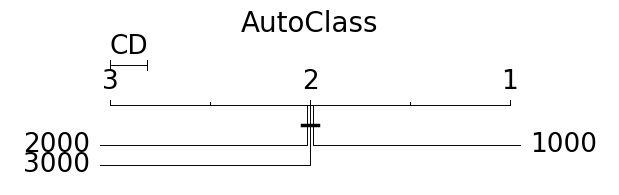


--- Analysis for energy_consumed ---
Paired samples: 319
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
2000  1.934169  1.322375  0.406107  1.157183  1.461008         0.0   
3000  2.003135  1.276100  0.412019  1.163808  1.515301      0.0763   
1000  2.062696  1.448289  0.662408   1.29056  1.661443   -0.154579   

       magnitude effect_size_above magnitude_above  
2000  negligible               0.0      negligible  
3000  negligible            0.0763      negligible  
1000  negligible         -0.210547           small  
METRIC energy_consumed
cd_diagrams of configs/exploration_window/energy_consumed/AutoClass.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/energy_consumed/AutoClass.png


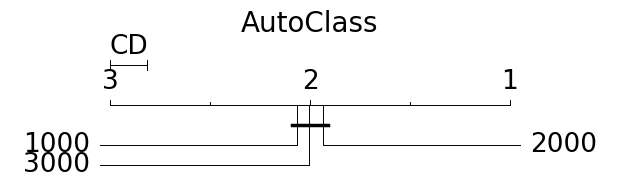


--- Analysis for time ---
Paired samples: 319
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
2000  1.959248  0.011111  0.003547  0.009871  0.012563         0.0   
3000  1.987461  0.011139  0.003436  0.009955  0.012543   -0.005305   
1000  2.053292  0.012460  0.006252  0.010096  0.014528   -0.178921   

       magnitude effect_size_above magnitude_above  
2000  negligible               0.0      negligible  
3000  negligible         -0.005305      negligible  
1000  negligible         -0.176613      negligible  


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


METRIC time
cd_diagrams of configs/exploration_window/time/AutoClass.png
Saved CD diagram to cd_diagrams of configs/exploration_window/time/AutoClass.png


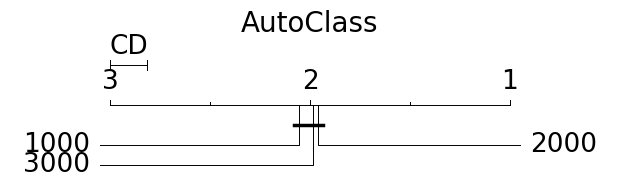


=== Analyzing AutoStreamML ===
Protected parameters: {}
Analyzing parameter: exploration_window
Available values: [1000, 2000, 3000]

--- Analysis for prequential_scores ---
Paired samples: 305
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
3000  2.331148  0.826149  0.091088  0.803109  0.870312         0.0   
1000  1.895082  0.815487  0.094856  0.811603  0.862743    0.077336   
2000  1.773770  0.853329   0.08015  0.805889  0.877363   -0.213682   

       magnitude effect_size_above magnitude_above  
3000  negligible               0.0      negligible  
1000  negligible          0.077336      negligible  
2000       small          -0.29067           small  
METRIC prequential_scores
cd_diagrams of configs/exploration_window/prequential_scores/ASML.png


/tmp/ipykernel_8473/2274633595.py:69: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['framework'].iloc[0]='ASML'
/tmp/ipykernel_8473/2274633595.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Saved CD diagram to cd_diagrams of configs/exploration_window/prequential_scores/ASML.png


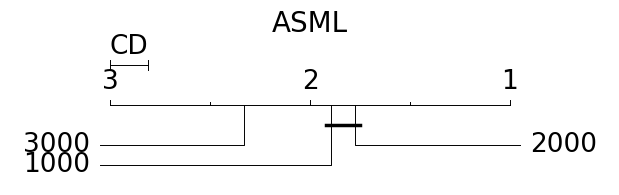


--- Analysis for energy_consumed ---
Paired samples: 305
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
2000  1.904918  0.688256  0.310534  0.558332  0.796817         0.0   
1000  1.970492  0.561482  0.204814  0.474014   0.70357    0.325077   
3000  2.124590  0.675417  0.292405  0.538505  0.843506    0.028713   

       magnitude effect_size_above magnitude_above  
2000  negligible               0.0      negligible  
1000       small          0.325077           small  
3000  negligible         -0.304425           small  
METRIC energy_consumed
cd_diagrams of configs/exploration_window/energy_consumed/ASML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/energy_consumed/ASML.png


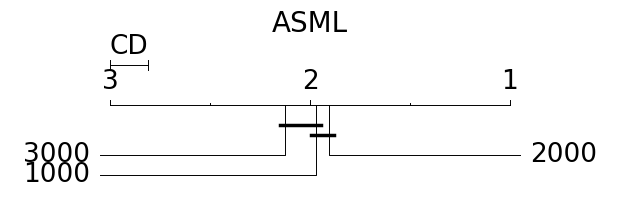


--- Analysis for time ---
Paired samples: 305
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
      meanrank    median       mad  ci_lower  ci_upper effect_size  \
1000  1.819672  0.003410  0.001679  0.002528  0.004595         0.0   
2000  1.918033  0.005007  0.002927  0.003981  0.006558   -0.451586   
3000  2.262295  0.005233   0.00292  0.003525  0.007014   -0.516403   

       magnitude effect_size_above magnitude_above  
1000  negligible               0.0      negligible  
2000       small         -0.451586           small  
3000      medium         -0.052124      negligible  
METRIC time
cd_diagrams of configs/exploration_window/time/ASML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/exploration_window/time/ASML.png


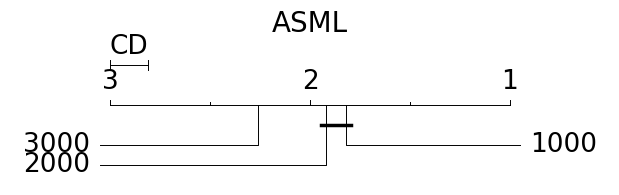

In [18]:
analyze_parameter(oaml_df, 'cache')
analyze_parameter(evoautoml_df, 'sampling_rate')
analyze_parameter(autoclass_df, 'exploration_window')
analyze_parameter(autostream_df, 'exploration_window')


=== Analyzing EvoAutoML ===
Protected parameters: {}
Analyzing parameter: population_size
Available values: [5, 10, 20]

--- Analysis for prequential_scores ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   2.436306  0.835199   0.07795   0.81977  0.862997         0.0  negligible   
10  1.949045  0.823545  0.053262  0.814886  0.840224    0.117743  negligible   
20  1.614650  0.868227  0.069978  0.833127  0.884057    -0.30075       small   

   effect_size_above magnitude_above  
5                0.0      negligible  
10          0.117743      negligible  
20         -0.484643           small  
METRIC prequential_scores
cd_diagrams of configs/population_size/prequential_scores/EvoAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/population_size/prequential_scores/EvoAutoML.png


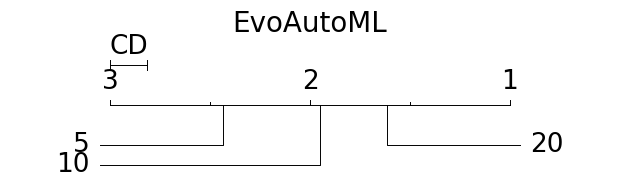


--- Analysis for energy_consumed ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.232484  0.489975  0.123291  0.455012  0.535289         0.0  negligible   
10  1.980892  0.881135  0.280064  0.774395   0.98146   -1.219333       large   
20  2.786624  1.483974  0.521036  1.287442  1.690319   -1.770838       large   

   effect_size_above magnitude_above  
5                0.0      negligible  
10         -1.219333           large  
20         -0.972102           large  
METRIC energy_consumed
cd_diagrams of configs/population_size/energy_consumed/EvoAutoML.png
Saved CD diagram to cd_diagrams of configs/population_size/energy_consumed/EvoAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


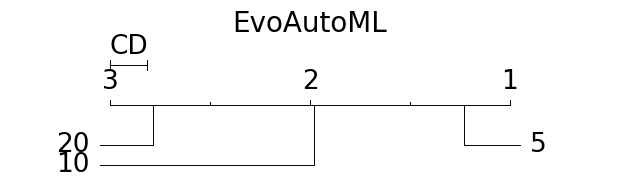


--- Analysis for time ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.242038  0.003109  0.001018  0.002775  0.003556         0.0  negligible   
10  1.917197  0.005736   0.00186  0.004869  0.007335   -1.182079       large   
20  2.840764  0.013006  0.004541  0.010339  0.014281   -2.028544       large   

   effect_size_above magnitude_above  
5                0.0      negligible  
10         -1.182079           large  
20           -1.4131           large  
METRIC time
cd_diagrams of configs/population_size/time/EvoAutoML.png
Saved CD diagram to cd_diagrams of configs/population_size/time/EvoAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


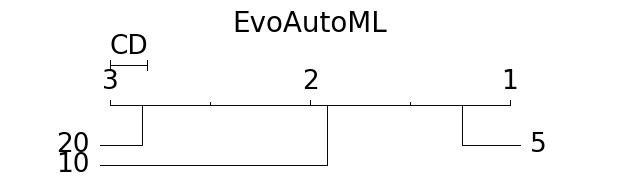


=== Analyzing AutoClass ===
Protected parameters: {}
Analyzing parameter: population_size
Available values: [5, 10, 20]

--- Analysis for prequential_scores ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   2.359873  0.784363  0.108129  0.762322  0.842699         0.0  negligible   
10  1.945860  0.823426  0.062659   0.77975  0.850441   -0.298154       small   
20  1.694268  0.802640  0.102685  0.785046  0.865465    -0.11691  negligible   

   effect_size_above magnitude_above  
5                0.0      negligible  
10         -0.298154           small  
20          0.164828      negligible  
METRIC prequential_scores
cd_diagrams of configs/population_size/prequential_scores/AutoClass.png
Saved CD diagram to cd_diagrams of configs/population_size/prequential_scores/AutoClass.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


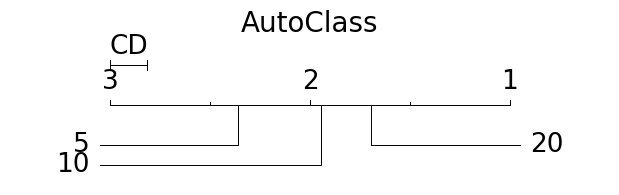


--- Analysis for energy_consumed ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.162420  0.686979  0.216383  0.629908  0.796322         0.0  negligible   
10  2.041401  1.490672   0.47697  1.360281     1.647   -1.463695       large   
20  2.796178  2.150354  0.462238   2.00692  2.344165   -2.734986       large   

   effect_size_above magnitude_above  
5                0.0      negligible  
10         -1.463695           large  
20         -0.947384           large  
METRIC energy_consumed
cd_diagrams of configs/population_size/energy_consumed/AutoClass.png
Saved CD diagram to cd_diagrams of configs/population_size/energy_consumed/AutoClass.png


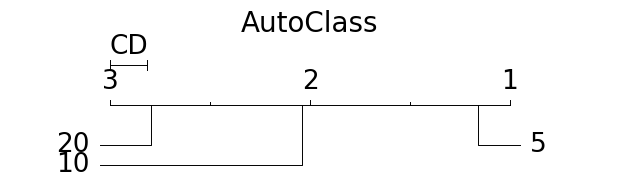


--- Analysis for time ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.168790  0.005294  0.002191  0.004874   0.00608         0.0  negligible   
10  2.031847  0.011889  0.003777  0.010527  0.013348   -1.440468       large   
20  2.799363  0.020059  0.004318  0.018358  0.021324   -2.908783       large   

   effect_size_above magnitude_above  
5                0.0      negligible  
10         -1.440468           large  
20         -1.358469           large  
METRIC time
cd_diagrams of configs/population_size/time/AutoClass.png
Saved CD diagram to cd_diagrams of configs/population_size/time/AutoClass.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


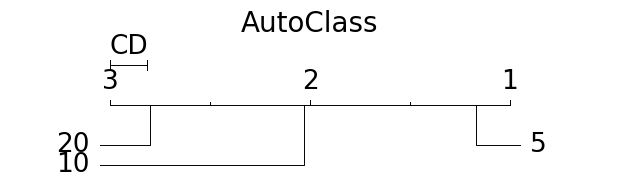


=== Analyzing OnlineAutoML ===
Protected parameters: {}
Analyzing parameter: ensemble_size
Available values: [5, 10, 15]

--- Analysis for prequential_scores ---
Paired samples: 256
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
10  2.027344  0.790285  0.086277  0.713466  0.805238         0.0  negligible   
15  2.000000  0.792140  0.111096   0.72652  0.816689   -0.012581  negligible   
5   1.972656  0.797209  0.122915  0.732453  0.818687    -0.04398  negligible   

   effect_size_above magnitude_above  
10               0.0      negligible  
15         -0.012581      negligible  
5          -0.029182      negligible  
METRIC prequential_scores
cd_diagrams of configs/ensemble_size/prequential_scores/OnlineAutoML.png
Saved CD diagram to cd_diagrams of configs/ensemble_size/prequential_scores/OnlineAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


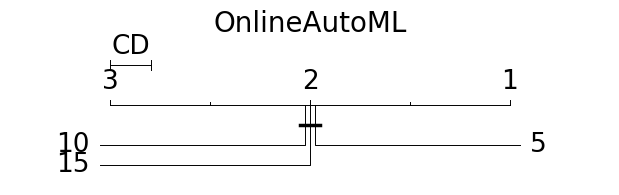


--- Analysis for energy_consumed ---
Paired samples: 256
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.925781  2.073230  0.618701  1.843555  2.489282         0.0  negligible   
15  1.945312  2.238809  0.865762  1.916804  2.922073   -0.148425  negligible   
10  2.128906  2.627040   1.09358  2.206758  3.088723   -0.420437       small   

   effect_size_above magnitude_above  
5                0.0      negligible  
15         -0.148425      negligible  
10         -0.265503           small  
METRIC energy_consumed
cd_diagrams of configs/ensemble_size/energy_consumed/OnlineAutoML.png
Saved CD diagram to cd_diagrams of configs/ensemble_size/energy_consumed/OnlineAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


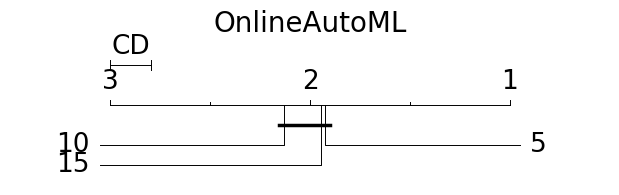


--- Analysis for time ---
Paired samples: 256
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.769531  2.105594  0.897169   1.86193  2.562642         0.0  negligible   
15  2.093750  2.565086  1.417577  2.109766   3.33333    -0.26126       small   
10  2.136719  2.596676  1.816094  2.006054  3.845334   -0.231254       small   

   effect_size_above magnitude_above  
5                0.0      negligible  
15          -0.26126           small  
10          -0.01308      negligible  
METRIC time
cd_diagrams of configs/ensemble_size/time/OnlineAutoML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/ensemble_size/time/OnlineAutoML.png


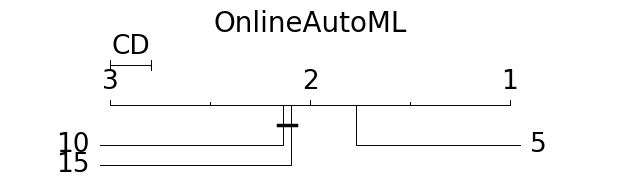


=== Analyzing ASML ===
Protected parameters: {}
Analyzing parameter: ensemble_size
Available values: [2, 3, 4, 5]

--- Analysis for prequential_scores ---
Paired samples: 299
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
   meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
2  2.903010  0.856041  0.077968  0.804084  0.888677         0.0  negligible   
3  2.408027  0.831040  0.078431  0.813761  0.876538    0.215632       small   
5  2.349498  0.870421  0.074705   0.80978  0.896571   -0.127035  negligible   
4  2.339465  0.872853  0.074186  0.808767  0.899129   -0.149008  negligible   

  effect_size_above magnitude_above  
2               0.0      negligible  
3          0.215632           small  
5         -0.346805           small  
4         -0.022029      negligible  
METRIC prequential_scores
cd_diagrams of configs/ensemble_size/prequential_scores/ASML.png
Saved CD diagram to cd_diagrams of configs/ensemb

/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


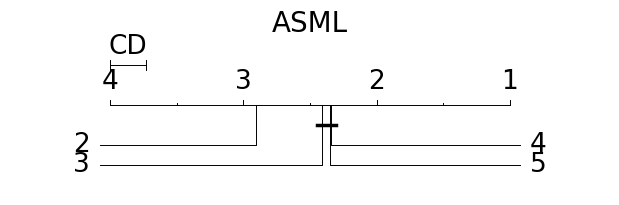


--- Analysis for energy_consumed ---
Paired samples: 299
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
   meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
2  1.836120  0.592544  0.207795  0.482154  0.673802         0.0  negligible   
3  2.204013  0.483944  0.158722  0.412794  0.616373    0.396175       small   
4  2.745819  0.785295  0.363316   0.59241  0.909886   -0.439285       small   
5  3.214047  0.829817  0.399336  0.630171  0.999648   -0.502767      medium   

  effect_size_above magnitude_above  
2               0.0      negligible  
3          0.396175           small  
4         -0.725019          medium  
5         -0.078663      negligible  
METRIC energy_consumed
cd_diagrams of configs/ensemble_size/energy_consumed/ASML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/ensemble_size/energy_consumed/ASML.png


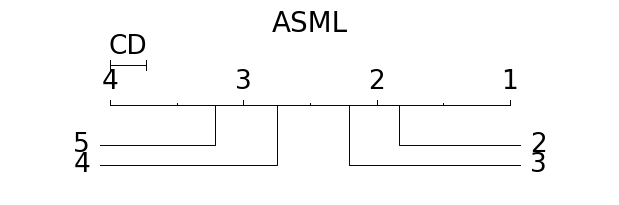


--- Analysis for time ---
Paired samples: 299
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
   meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
2  1.605351  0.004017   0.00216  0.002658  0.004727         0.0  negligible   
3  2.197324  0.002557  0.001195   0.00228  0.004029    0.563879      medium   
4  2.846154  0.005665  0.003543  0.003856  0.007298   -0.378728       small   
5  3.351171  0.006053  0.003902  0.004157  0.008102   -0.435367       small   

  effect_size_above magnitude_above  
2               0.0      negligible  
3          0.563879          medium  
4         -0.792619          medium  
5         -0.070222      negligible  
METRIC time
cd_diagrams of configs/ensemble_size/time/ASML.png
Saved CD diagram to cd_diagrams of configs/ensemble_size/time/ASML.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


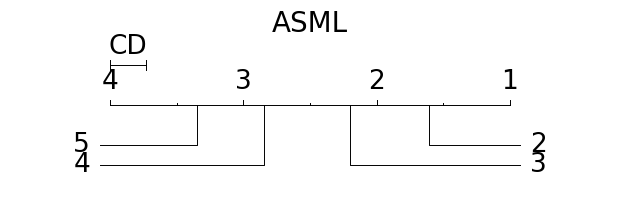

In [19]:
analyze_parameter(evoautoml_df, 'population_size')
analyze_parameter(autoclass_df, 'population_size')

analyze_parameter(oaml_df, 'ensemble_size')
analyze_parameter(autostream_df, 'ensemble_size')


=== Analyzing OnlineAutoML ===
Protected parameters: {}
Analyzing parameter: time_budget
Available values: [30, 60, 90]

--- Analysis for prequential_scores ---
Paired samples: 209
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
60  2.052632  0.793726  0.089362  0.715012  0.808806         0.0  negligible   
30  2.014354  0.788278  0.114853  0.723646   0.80764    0.035709  negligible   
90  1.933014  0.795666  0.129033  0.734565  0.848473    -0.01179  negligible   

   effect_size_above magnitude_above  
60               0.0      negligible  
30          0.035709      negligible  
90         -0.040795      negligible  
METRIC prequential_scores
cd_diagrams of configs/special/OnlineAutoML/prequential_scores.png
Saved CD diagram to cd_diagrams of configs/special/OnlineAutoML/prequential_scores.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


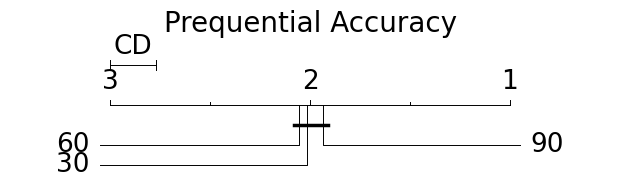


--- Analysis for energy_consumed ---
Paired samples: 209
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
30  1.464115  1.613422  0.665606  1.423794  2.111205         0.0  negligible   
60  2.062201  2.656815  1.018899  2.158843  3.146371   -0.817776       large   
90  2.473684  3.424097   1.24512  2.938434  4.187657   -1.223318       large   

   effect_size_above magnitude_above  
30               0.0      negligible  
60         -0.817776           large  
90         -0.454908           small  
METRIC energy_consumed
cd_diagrams of configs/special/OnlineAutoML/energy_consumed.png
Saved CD diagram to cd_diagrams of configs/special/OnlineAutoML/energy_consumed.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


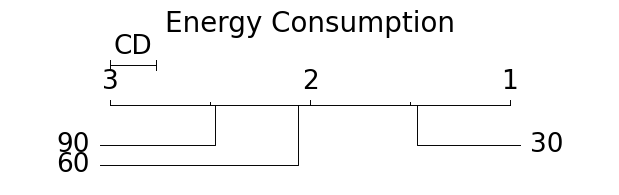

/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



--- Analysis for time ---
Paired samples: 209
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
30  1.712919  1.929522  1.096249  1.530647  2.505064         0.0  negligible   
60  2.105263  2.707958  1.797438  2.006054  3.653049   -0.352686       small   
90  2.181818  3.099561  1.560569  2.453566  3.757715    -0.58521      medium   

   effect_size_above magnitude_above  
30               0.0      negligible  
60         -0.352686           small  
90         -0.156925      negligible  
METRIC time
cd_diagrams of configs/special/OnlineAutoML/time.png
Saved CD diagram to cd_diagrams of configs/special/OnlineAutoML/time.png


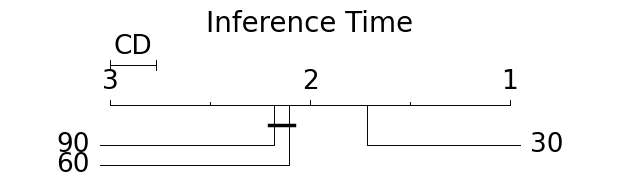


=== Analyzing EvoAutoML ===
Protected parameters: {}
Analyzing parameter: sampling_size
Available values: [1, 2, 3]

--- Analysis for prequential_scores ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
   meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
2  2.004777  0.848711  0.071193  0.829182  0.876038         0.0  negligible   
3  2.004777  0.848711  0.071193  0.829182  0.876038         0.0  negligible   
1  1.990446  0.827749  0.049794  0.816171  0.850228    0.230145       small   

  effect_size_above magnitude_above  
2               0.0      negligible  
3               0.0      negligible  
1          0.230145           small  
METRIC

/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


 prequential_scores
cd_diagrams of configs/special/EvoAutoML/prequential_scores.png
Saved CD diagram to cd_diagrams of configs/special/EvoAutoML/prequential_scores.png


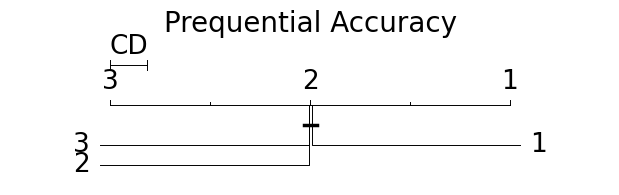


--- Analysis for energy_consumed ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
   meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
1  1.968153  0.834838  0.304654  0.711997  0.987445         0.0  negligible   
2  2.012739  0.836274  0.249169  0.751067  0.980937   -0.003479  negligible   
3  2.019108  0.917054  0.274907  0.769271  1.010011   -0.191112  negligible   

  effect_size_above magnitude_above  
1               0.0      negligible  
2         -0.003479      negligible  
3         -0.207678           small  
METRIC energy_consumed
cd_diagrams of configs/special/EvoAutoML/energy_consumed.png
Saved CD diagram to cd_diagrams of configs/special/EvoAutoML/energy_consumed.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


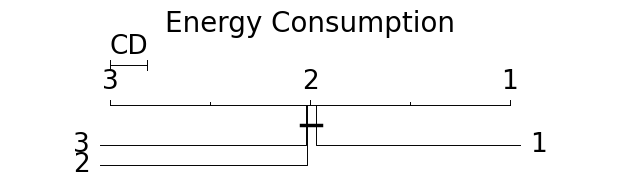


--- Analysis for time ---
Paired samples: 314
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
   meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
1  1.958599  0.005638  0.002339  0.004648   0.00757         0.0  negligible   
3  1.977707  0.006613  0.002412  0.005643  0.007252   -0.276707       small   
2  2.063694  0.006817   0.00259  0.005434  0.007238   -0.322194       small   

  effect_size_above magnitude_above  
1               0.0      negligible  
3         -0.276707           small  
2         -0.054989      negligible  
METRIC time
cd_diagrams of configs/special/EvoAutoML/time.png
Saved CD diagram to cd_diagrams of configs/special/EvoAutoML/time.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


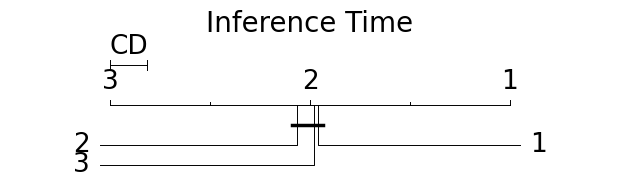


=== Analyzing ASML ===
Protected parameters: {}
Analyzing parameter: budget
Available values: [5, 10, 15]

--- Analysis for prequential_scores ---
Paired samples: 272
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
15  2.102941  0.850203  0.081862  0.805327  0.894037         0.0  negligible   
10  2.000000  0.854565   0.07107  0.810972  0.909471   -0.038382  negligible   
5   1.897059  0.873860  0.071901  0.814108  0.894798   -0.207116       small   

   effect_size_above magnitude_above  
15               0.0      negligible  
10         -0.038382      negligible  
5          -0.182054      negligible  
METRIC prequential_scores
cd_diagrams of configs/special/ASML/prequential_scores.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved CD diagram to cd_diagrams of configs/special/ASML/prequential_scores.png


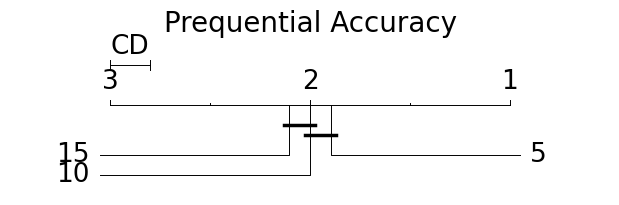


--- Analysis for energy_consumed ---
Paired samples: 272
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.540441  0.457613  0.191995  0.371287   0.59439         0.0  negligible   
15  2.227941  0.833212   0.36157   0.61845   0.94882   -0.875153       large   
10  2.231618  0.713851  0.288117  0.594549  0.803192   -0.705948      medium   

   effect_size_above magnitude_above  
5                0.0      negligible  
15         -0.875153           large  
10          0.246267           small  
METRIC energy_consumed
cd_diagrams of configs/special/ASML/energy_consumed.png
Saved CD diagram to cd_diagrams of configs/special/ASML/energy_consumed.png


/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


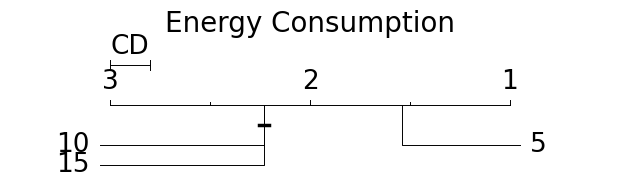

/tmp/ipykernel_8473/2274633595.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



--- Analysis for time ---
Paired samples: 272
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
    meanrank    median       mad  ci_lower  ci_upper effect_size   magnitude  \
5   1.507353  0.002939  0.001817  0.001871   0.00432         0.0  negligible   
10  2.176471  0.004712  0.002567  0.003759  0.005584   -0.537816      medium   
15  2.316176  0.006158   0.00338  0.004794  0.007724   -0.800014       large   

   effect_size_above magnitude_above  
5                0.0      negligible  
10         -0.537816          medium  
15         -0.324893           small  
METRIC time
cd_diagrams of configs/special/ASML/time.png
Saved CD diagram to cd_diagrams of configs/special/ASML/time.png


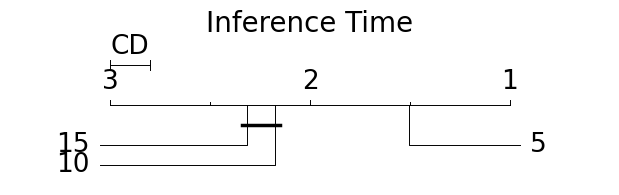

In [20]:
analyze_parameter(oaml_df, 'time_budget')
analyze_parameter(evoautoml_df, 'sampling_size')
analyze_parameter(autostream_df, 'budget')